In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras

from tensorflow.keras.applications import vgg19
# from keras.utils import plot_model

In [47]:
style = "https://images.newscientist.com/wp-content/uploads/2019/06/03121817/a2wxxe.jpg?width=1200"
image = "https://sohu-shop.se/images/tapet_new/tiger-photo-wallpaper-wall-mural-1964wm-2-p.jpg"

style_image_path = tf.keras.utils.get_file(fname = "Psycadelics.jpg", origin = style)
base_image_path = tf.keras.utils.get_file(fname = "Tiger.jpg", origin = image)

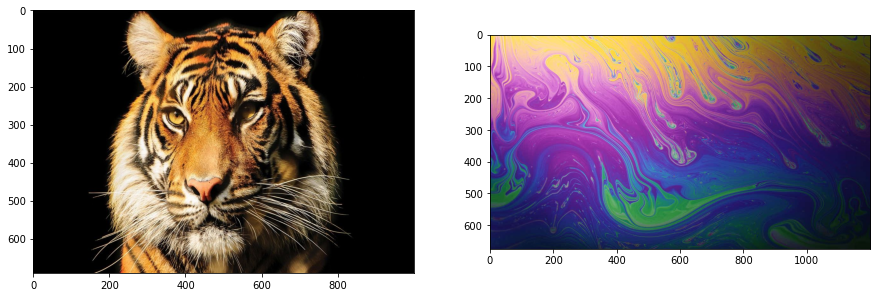

In [48]:
def ShowImages():
    a = plt.imread(base_image_path)
    b = plt.imread(style_image_path)
    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(a)
    axarr[1].imshow(b)
    plt.show()
ShowImages()

In [49]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
    
def coste_estilo(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def coste_contenido(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [50]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:
from keras import Model

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

In [52]:
capas_estilo = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

capas_contenido = "block5_conv2"

content_weight = 2.5e-8
style_weight = 1e-6

In [53]:
def loss_function(combination_image, base_image, style_reference_image):

    # 1. Combine all the images in the same tensioner.
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    # 2. Get the values in all the layers for the three images.
    features = feature_extractor(input_tensor)

    #3. Inicializar the loss

    loss = tf.zeros(shape=())

    # 4. Extract the content layers + content loss
    layer_features = features[capas_contenido]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * coste_contenido(
        base_image_features, combination_features
    )
    # 5. Extraer the style layers + style loss
    for layer_name in capas_estilo:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = coste_estilo(style_reference_features, combination_features)
        loss += (style_weight / len(capas_estilo)) * sl

    return loss

In [54]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [55]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [56]:
def deprocess_image(x):

    # Convertimos el tensor en Array
    x = x.reshape((img_nrows, img_ncols, 3))

    # Hacemos que no tengan promedio 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Convertimos de BGR a RGB.
    x = x[:, :, ::-1]

    # Nos aseguramos que están entre 0 y 255
    x = np.clip(x, 0, 255).astype("uint8")

    return x

In [57]:
from datetime import datetime

def result_saver(iteration):
  # Create name
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  #model_name = str(i) + '_' + str(now)+"_model_" + '.h5'
  image_name = str(i) + '_' + str(now)+"_image" + '.png'

  # Save image
  img = deprocess_image(combination_image.numpy())
  keras.preprocessing.image.save_img(image_name, img)

In [58]:


width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 5000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i)

Iteration 10: loss=11042.19
Iteration 20: loss=7309.98
Iteration 30: loss=5806.57
Iteration 40: loss=4651.65
Iteration 50: loss=4092.53
Iteration 60: loss=3712.17
Iteration 70: loss=3368.68
Iteration 80: loss=3131.21
Iteration 90: loss=2944.45
Iteration 100: loss=2767.09
Iteration 110: loss=2638.04
Iteration 120: loss=2512.67
Iteration 130: loss=2411.06
Iteration 140: loss=2320.16
Iteration 150: loss=2239.45
Iteration 160: loss=2167.97
Iteration 170: loss=2103.43
Iteration 180: loss=2044.78
Iteration 190: loss=1991.62
Iteration 200: loss=1942.85
Iteration 210: loss=1898.14
Iteration 220: loss=1857.03
Iteration 230: loss=1818.84
Iteration 240: loss=1783.48
Iteration 250: loss=1750.44
Iteration 260: loss=1719.44
Iteration 270: loss=1690.40
Iteration 280: loss=1663.27
Iteration 290: loss=1637.59
Iteration 300: loss=1613.53
Iteration 310: loss=1590.83


KeyboardInterrupt: 